<a href="https://colab.research.google.com/github/rakibulhaque9954/Machine_Learning_Translation/blob/main/Machine_translation_Bahdanau_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acknowledgement

**Based on research by Dzmitry Bahdanau**<br>
Paper Link: https://arxiv.org/pdf/1409.0473.pdf


# Imports

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

## Dataset Download

In [2]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-10-22 07:43:06--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757635 (7.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.40M  4.27MB/s    in 1.7s    

2023-10-22 07:43:09 (4.27 MB/s) - ‘fra-eng.zip’ saved [7757635/7757635]



In [3]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Data Preprocessing

In [4]:
text_dataset = tf.data.TextLineDataset("/content/dataset/fra.txt")

In [5]:
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LENGTH = 64
FRENCH_SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 300
BATCH_SIZE = 64

In [6]:
english_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [7]:
french_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [8]:
def selector(input_text):
  split_text = tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [9]:
split_dataset = text_dataset.map(selector)

In [10]:
def separator(input_text):
  split_text = tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [11]:
init_dataset = text_dataset.map(separator)

In [12]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


### Vocabulary Creation

In [13]:
english_training_data=init_dataset.map(lambda x,y:x) # input x,y and output x
english_vectorize_layer.adapt(english_training_data) # adapt the vectorize_layer to the training data

french_training_data=init_dataset.map(lambda x,y:y) # input x,y,z and output y
french_vectorize_layer.adapt(french_training_data) # adapt the vectorize_layer to the training data

### Grouping and Vectorizing for training

In [14]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [15]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [16]:
dataset=split_dataset.map(vectorizer)

In [17]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [18]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [19]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [20]:
dataset = dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [21]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [22]:
NUM_BATCHES = int(200000/BATCH_SIZE)

### Dataset Split

In [23]:
train_dataset = dataset.take(int(0.9*NUM_BATCHES))
val_dataset = dataset.skip(int(0.9*NUM_BATCHES))

In [24]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# Modeling

<hr>
<h4>Model Architecture</h4>
<hr>
<img src='https://www.researchgate.net/publication/330924206/figure/fig2/AS:723516190121985@1549511110958/Architecture-of-RNNsearch-Bahdanau-et-al-2015-left-and-its-attention-model-right.jpg'>

***Step Wise Explanation:***
<br>
Bahdanau mechanisms help the model decide which parts of the source sentence to pay attention to while generating the corresponding words in the target language. Here's a simplified overview:

- Encoder-Decoder Architecture: The neural network used for translation consists of two main parts: the encoder and the decoder. The encoder processes the input sentence, creating a hidden representation that captures the meaning of the sentence. Think of it as encoding the source language's information.
- Attention Mechanism: The attention mechanism, which Bahdanau introduced. It allows the model to focus on specific parts of the input sentence while generating each word in the output sentence. can be imagined as a spotlight that helps the model decide where to look while translating.
- Alignment Scores: For each word in the target sentence, the model calculates alignment scores for each word in the source sentence. These scores indicate how relevant each word in the source sentence is to generating the current word in the target sentence.
- Softmax and Weighted Sum: The alignment scores go through a softmax function to turn them into probabilities. This ensures that the model gives more attention to words with higher scores. The weighted sum of the encoder's hidden states, using these probabilities, is used as context information for generating the current target word.
- Generating Output: The decoder, armed with this context information, generates the next word in the target sentence. It does this one word at a time, using the previously generated words as input.
- Repeat and Refine: The process repeats for each word in the target sentence, with the decoder updating its internal state based on the previously generated words.
- End of Sentence: The model generates words until it predicts an end-of-sentence token or reaches a predefined maximum length for the translation.

***More detailed overview of the Attention mechanism***
<br>
Let's use the example 'I love apples' sequence to better illustrate the process:

1. **Encoding**:
   - Each word in the input sentence "I love apples" is encoded into a vector by the encoder, resulting in vectors (v_I, v_{love}, v_{apples}).

2. **Initialization**:
   - The decoder starts with a start token, say `<START>`.

3. **Attention Weights Calculation (1st Word)**:
   - For translating the first word, attention weights are calculated based on the initial state of the decoder and each vector from the encoder.
   - Let’s assume the raw attention scores are higher for the word "I", say (a = [0.7, 0.2, 0.1]) respectively for(v_I, v_{love}, v_{apples}).

4. **Softmax Normalization (1st Word)**:
   - Applying the softmax function to these scores: softmax(a) = [0.496, 0.247, 0.247]\).

5. **Context Vector Generation (1st Word)**:
   - The context vector is then formed by the weighted sum of the encoder vectors:
     context_1 = 0.496.v_I + 0.247.v_{love} + 0.247.v_{apples}.

6. **Translation and Decoder Update (1st Word)**:
   - This context vector, along with the decoder's state, is used to predict the first word in the French translation, "J'", and to update the decoder's state for the next word prediction.

The process continues in a similar fashion for the remaining words, with attention weights reflecting the relevance of each word in the input sequence for the current word being translated in the output sequence. For instance, when translating "aime" (love), the attention weight should be higher for "love", and when translating "les pommes" (the apples), the attention weight should be higher for "apples". This way, the attention mechanism allows the model to focus on the relevant parts of the input sequence for each word in the translation, aiding in a more accurate and contextually grounded translation.

## Bahdanau Architecture

### Encoder

In [25]:
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, lstm_units):
    super(Encoder, self).__init__()
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    self.lstm_units = lstm_units


  def build(self, input_shape):
    self.embedding = Embedding(self.vocab_size, self.embedding_dim)
    self.lstm = LSTM(self.lstm_units, return_sequences=True) # returning each output from each block for subvectors attention

  def call(self, x):
    x = self.embedding(x)
    output = self.lstm(x)
    return output

In [55]:
HIDDEN_UNITS = 256
EMBEDDING_DIM = 256

encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS)
encoder_output = encoder(tf.zeros([128, 8])) # suppose pass an input of [batch_size, sequence_length]
print(encoder_output.shape)


(128, 8, 256)


### Bahdanau Attention Layer

In [56]:
class BahdanauAttention(Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.units = units

  def build(self, input_shape):
    self.w_1 = Dense(self.units)
    self.w_2 = Dense(self.units)
    self.w = Dense(1)

  def call(self, prev_decoder_state, encoder_states):
    scores = self.w(
        tf.nn.tanh(
            self.w_1(tf.expand_dims(prev_decoder_state, -2)) +
            self.w_2(encoder_states)))

    attention_weights = tf.nn.softmax(scores, axis=1)
    context_vector = attention_weights * encoder_states
    context_vector = tf.reduce_sum(context_vector, axis=1) # condensing to one vector
    return context_vector, attention_weights




In [57]:
bahdanau_attention=BahdanauAttention(256)
context_vector,attention_weights=bahdanau_attention(tf.zeros([128,32]),tf.zeros([128,8,32])) # Encoder states[batch_size, sequence_length, encoded_dims]
print(context_vector.shape) # tf.reduce_sum operation is used to reduce the
# dimensions along the sequence_length axis, effectively computing a weighted sum of the encoder_states
print(attention_weights.shape)



(128, 32)
(128, 8, 1)


### Decoder

In [72]:
class Decoder(Model):
  def __init__(self, vocab_size, embedding_dim, decoder_units, sequence_length):
    super(Decoder, self).__init__()
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    self.decoder_units = decoder_units
    self.sequence_length = sequence_length

  def build(self, input_shape):
    self.dense = Dense(self.vocab_size, activation='softmax')
    self.gru = GRU(
        self.decoder_units, return_sequences=True, return_state=True)
    self.attention = BahdanauAttention(self.decoder_units)
    self.embedding = Embedding(self.vocab_size, self.embedding_dim)

  def call(self, x, hidden, shifted_target):
    outputs = []
    context_vectors = []
    attention_weightss = []
    shifted_target = self.embedding(shifted_target)

    for t in range(0, self.sequence_length):
      context_vector, attention_weights = self.attention(hidden, x) # Updated variable name to avoid conflict
      decoder_input = context_vector + shifted_target[:, t]
      output, hidden = self.gru(tf.expand_dims(decoder_input, 1)) # expanding dims
      outputs.append(output[:, 0])

    outputs = tf.convert_to_tensor(outputs)
    # print("Shape of outputs before transpose:", outputs.shape)
    outputs = tf.transpose(outputs, perm=[1, 0, 2]) # permuted the positions of the outputs, basically just changing the shape

    outputs = self.dense(outputs)

    return outputs, attention_weights


In [76]:
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS, FRENCH_SEQUENCE_LENGTH)
outputs,attention_weights = decoder(encoder_output, tf.zeros([128,HIDDEN_UNITS]),tf.zeros([128,64]))
print(outputs.shape)
print(attention_weights.shape)

(128, 64, 20000)
(128, 64, 1)


### Full Model

In [77]:
### ENCODER ###
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype='int64', name='input_1')
encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS)
encoder_output = encoder(input)

### DECODER ###
shifted_target = Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype='int64', name='input_2')
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_UNITS, FRENCH_SEQUENCE_LENGTH) # initializing initial state of decoder
decoder_output, attention_weightss = decoder(encoder_output, tf.zeros([1, HIDDEN_UNITS]), shifted_target)

### OUTPUT ###
bahdanau_model = Model(inputs=[input, shifted_target], outputs=decoder_output)
bahdanau_model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 encoder_8 (Encoder)         (None, 64, 256)              5645312   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 decoder_15 (Decoder)        ((None, 64, 20000),          1078659   ['encoder_8[0][0]',           
                              (None, 64, 1))              3          'input_2[0][0]']       

### BLEU Metric

In [78]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [83]:
bahdanau_model.compile(
    optimizer=Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[BLEU()],
    run_eagerly=True)



In [80]:
history = bahdanau_model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset)

Epoch 1/15
2812/2812 [==============================] - 1014s 321ms/step - loss: 1.0310 - val_loss: 1.0754
Epoch 2/15
2812/2812 [==============================] - 825s 293ms/step - loss: 0.5372 - val_loss: 1.0082
Epoch 3/15
2812/2812 [==============================] - 865s 308ms/step - loss: 0.4861 - val_loss: 0.9377
Epoch 4/15
2812/2812 [==============================] - 831s 295ms/step - loss: 0.4453 - val_loss: 0.9000
Epoch 5/15
2812/2812 [==============================] - 824s 293ms/step - loss: 0.4143 - val_loss: 0.8747
Epoch 6/15
2812/2812 [==============================] - 825s 293ms/step - loss: 0.3907 - val_loss: 0.8464
Epoch 7/15
2812/2812 [==============================] - 838s 298ms/step - loss: 0.3685 - val_loss: 0.8299
Epoch 8/15
2812/2812 [==============================] - 824s 293ms/step - loss: 0.3480 - val_loss: 0.8021
Epoch 9/15
2812/2812 [==============================] - 823s 292ms/step - loss: 0.3297 - val_loss: 0.7809
Epoch 10/15
2812/2812 [======================

In [81]:
bahdanau_model.save('/content/drive/MyDrive/bahdanau_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Loss Graph

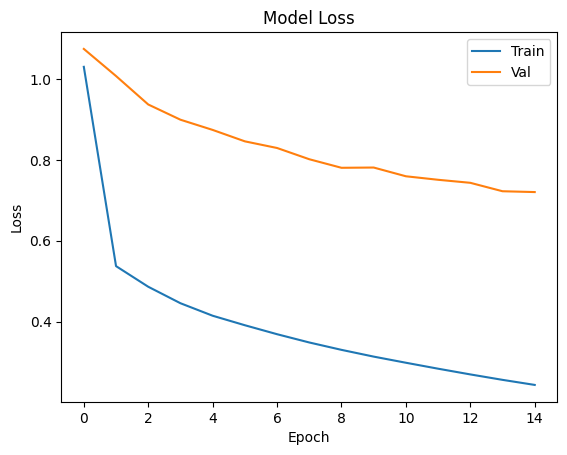

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Testing and Evalaution

In [86]:
bahdanau_model.evaluate(val_dataset)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    508/Unknown - 3604s 7s/step - loss: 0.5530 - bleu_2: 0.3521

KeyboardInterrupt: ignored

***BLEU score achieved was quite low becuase of less training.***

In [87]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [88]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output = bahdanau_model.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

## Translation test

In [89]:
print("Google Translate: Qu'est-ce qui vous fait penser que ce n'est pas vrai ?")
translator('What makes you think that it is not true?')

Google Translate: Qu'est-ce qui vous fait penser que ce n'est pas vrai ?
1/1 [==============================] - 1s 697ms/step


'questce qui ne va pas que je ne pas être vrai'

In [90]:
print("Google Translate: Avez-vous déjà regardé du football sous la pluie ?")
translator('Have you ever watched soccer under the rain?')

Google Translate: Avez-vous déjà regardé du football sous la pluie ?
1/1 [==============================] - 1s 717ms/step


'astu déjà vu la lettre à la bibliothèque'

In [91]:
print("Google Translate: Les grands arbres ne poussent pas facilement, plus les vents sont forts, plus les arbres sont forts")
translator('Great trees do not grow with ease, the stronger the winds, the stronger the trees')


Google Translate: Les grands arbres ne poussent pas facilement, plus les vents sont forts, plus les arbres sont forts
1/1 [==============================] - 1s 734ms/step


'les gens ne sont pas la plus de la nuit'

#Verdict

Longer translations accuracy is low because the dataset fed consists of short sentences, overall the BLEU score is low, more training is required with a faster GPU.